In [1]:
from utils_01_06 import *

C:\Users\ms\Desktop\lane-detection\python\utils_31_05.py:74: RuntimeWarning: invalid value encountered in float_scalars
  tan = rad2deg(math.atan(-gx[y,x] / gy[y,x]))
C:\Users\ms\Desktop\lane-detection\python\utils_31_05.py:74: RuntimeWarning: divide by zero encountered in float_scalars
  tan = rad2deg(math.atan(-gx[y,x] / gy[y,x]))


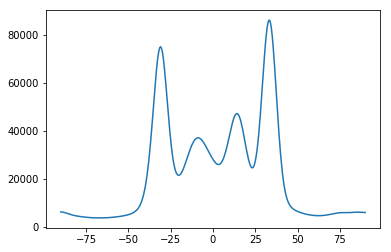

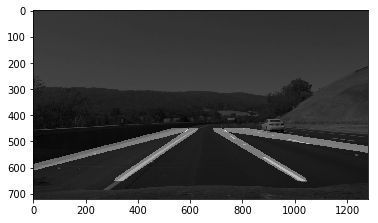

[-30.8356546   -8.77437326  14.28969359  33.84401114]


In [2]:
img_orig = mpimg.imread('img/test3.jpg')
img = img_orig[470:650,:]
#test = np.ones((100, 500))#img[470:650, 100:1200]
gray = rgb2gray(img_orig)
y, tan_arr, mag_arr = edf_comp(img)
edges, vm = get_edges_thetas(y, tan_arr, mag_arr)
gray_lines, lbrois = draw_on_img(gray, edges, vm, mag_arr, 470, 650, thicc=24)
gshow(gray_lines)
#print(len(edges))
print(vm)

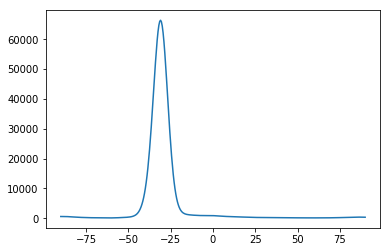

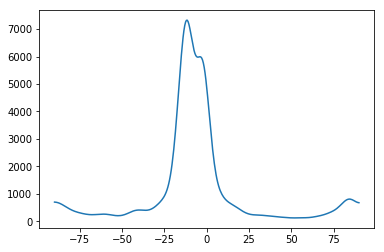

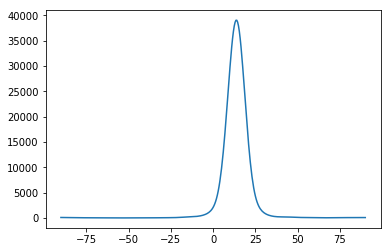

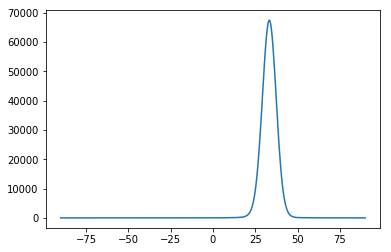

In [3]:
YM = 550
aeim = get_new_angles_edges(img_orig, lbrois)

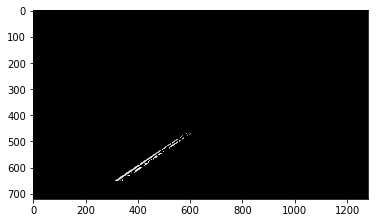

In [4]:
test_edge = aeim[3][1]
gshow(test_edge)

'''
    Get weight matrix of parabolic function from single edge image

    Parameters:
    
        edge_img : single edge image
        
        YM : near far field threshold
        
    Return:
    
        C : [a, b, d]T weight matrix, shape of (3, 1)

'''

def solver(edge_img, YM=YM):
    far_field = np.zeros_like(test_edge)
    near_field = np.zeros_like(test_edge)

    far_field[:YM, :] = test_edge[:YM, :]
    near_field[YM:, :] = test_edge[YM:, :]
    
    far_non = np.nonzero(far_field)
    near_non = np.nonzero(near_field)
    tfar_non = np.transpose(far_non)
    tnear_non = np.transpose(near_non)
    
    n = tfar_non.shape[0]
    m = tnear_non.shape[0]
    
    mag_n = far_field[far_non]
    mag_f = near_field[near_non]
    mag_nf = np.hstack((mag_n, mag_f))

    A = np.zeros((n+m, 3))
    W = np.diag(mag_nf)  
    C = np.zeros((3, 1))
    B = np.zeros((n+m, 1))
    
    A[:, 0] = 1
    A[:m, 1] = tnear_non[:, 0]#.reshape((m, 1))
    B[:m, 0] = tnear_non[:, 1]#.reshape((m, 1))
    B[m:, 0] = tfar_non[:, 1]#.reshape((n, 1))
    yf = tfar_non[:, 0]#.reshape((n, 1))
    yf2 = np.power(yf, 2)
    
    A1 = (yf2 + math.pow(YM, 2)) / (2 * YM)
    A2 = (-1) * np.power((yf - YM), 2) / (2 * YM)
    
    A[m:, 1] = A1
    A[m:, 2] = A2
    f_side = np.matmul(np.matmul(np.transpose(A), W), A)
    s_side = np.matmul(np.matmul(np.transpose(A), W), B)
    f_side_inv = inv(f_side)
    C = np.matmul(f_side_inv, s_side)
    
    return C


'''
    Puts weights into function
    
    Parameter:
    
        C : weight matrix
        
        y : y value, scalar
        
        YM : near far field threshold
        
    Return:
    
        x_val: x value

'''

def quad_linear(C, y, YM=YM):
    a = C[0, 0]
    b = C[1, 0]
    d = C[2, 0]
    
    if (y > YM):
        x_val = a + b*y
        return x_val
    else:
        x_val = ((a + (YM/2) * (b - d))) + d * y + (math.pow(y, 2) / (2 * YM)) * (b-d)
        return x_val

In [5]:
C = solver(test_edge)

original plot


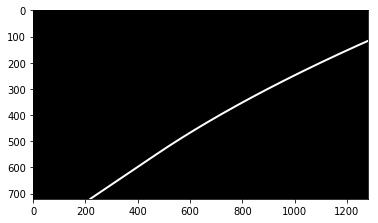

cropped


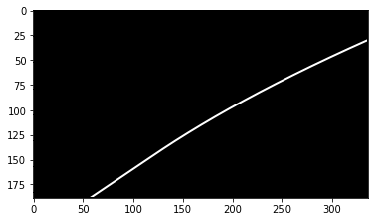

resized


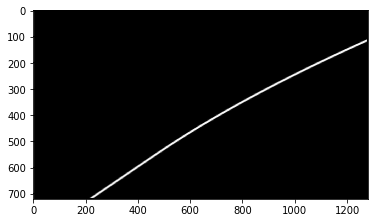

plot on resized


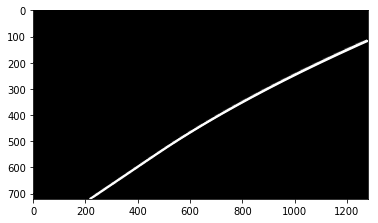

In [114]:
from skimage import color
y = np.linspace(0, 720, 1440)
x = np.zeros_like(y)

for i in range(y.shape[0]):
    x[i] = quad_linear(C, y[i])

test_res = np.zeros_like(test_edge).astype(np.uint8)

print('original plot')
fig, ax = plt.subplots()
ax.imshow(test_res, plt.get_cmap('gray'))
ax.plot(x, y, 'w-', linewidth=2)
plt.xlim(0, 1280)
plt.ylim(720, 0)
fig.canvas.draw()

data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

#width, height = fig.get_size_inches() * 200

#mplimage = np.fromstring(fig.canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
#gray_img = color.rgb2gray(mplimage)
plt.show()


d = data[49:238, 53:390]
print('cropped')
gshow(d)
d_rs = cv2.resize(d, (1280, 720))
print('resized')
gshow(d_rs)


print('plot on resized')
fig1, ax1 = plt.subplots()
ax1.imshow(d_rs, plt.get_cmap('gray'))
ax1.plot(x, y, 'w-', linewidth=2)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

def parabola_image(edge_image, C, lw=3):
    y = np.linspace(0, 720, 1440)
    x = np.zeros_like(y)

    for i in range(y.shape[0]):
        x[i] = quad_linear(C, y[i])
        
    blank = np.zeros_like(edge_image).astype(np.uint8)
    fig, ax = plt.subplots()
    ax.imshow(test_res, plt.get_cmap('gray'))
    ax.plot(x, y, 'w-', linewidth=lw)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    d = data[49:238, 53:390] # crop plot
    plot_image = cv2.resize(d, (1280, 720)) # resize to original dims
    plot_image = rgb2gray(plot_image)
    
    plt.close(fig)
    
    return plot_image

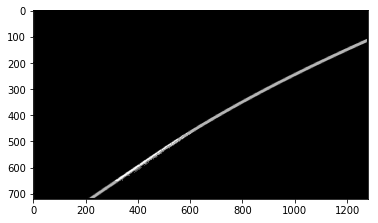

In [116]:
plot_im = parabola_image(test_edge, C)
gshow(test_edge + plot_im)
def normal_eq(X, y):
    '''
    Parameters:
    
        X : data matrix
        
        y : expected estimation values
    
    Return:
    
        theta : weight matrix
    
    '''
    
    XTX = np.matmul(np.transpose(X), X)
    XTy = np.matmul(np.transpose(X), y)
    theta = np.matmul(np.linalg.inv(XTX), XTy)
    
    return theta

In [106]:
def quad(data, vals):
    '''
    Parameters:
    
        data : shape of (m, 1)
        
        vals : expected estimation values, shape of (m, 1)
    
    Return:
    
        theta : weight matrix, shape of (3, 1)
    
    '''
    
    D = np.hstack((np.hstack((data, np.power(data, 2))), np.ones_like(data)))
    
    theta = normal_eq(D, vals)
    
    return theta

In [44]:
def linear(data, vals):
    '''
    Parameters:
    
        data : shape of (m, 1)
        
        vals : expected estimation values, shape of (m, 1)
    
    Return:
    
        theta : weight matrix, shape of (2, 1)
    
    '''
    D = np.hstack((np.ones_like(data), data))
    
    theta = normal_eq(D, vals)
    
    return theta

In [58]:
YM = 550

far_field = np.zeros_like(test_edge)
near_field = np.zeros_like(test_edge)

far_field[:YM, :] = test_edge[:YM, :]
near_field[YM:, :] = test_edge[YM:, :]
    
far_non = np.nonzero(far_field)
near_non = np.nonzero(near_field)
tfar_non = np.transpose(far_non)
tnear_non = np.transpose(near_non)

n = tfar_non.shape[0]
m = tnear_non.shape[0]

l = linear(tnear_non[:, 0].reshape((m, 1)), tnear_non[:, 1].reshape((m, 1)))
print(l.shape)
print(l)

(2, 1)
[[ 1292.39499764]
 [   -1.49187576]]


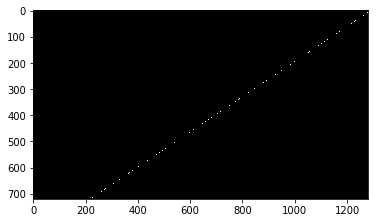

In [59]:
#print(C)
#gshow(test_res)
#gshow(test_edge)
#gshow(test_edge + test_res)

def linear_draw(edge_img, theta):
    ret_im = np.zeros_like(edge_img)
    for y in range(720):
        x = np.matmul(np.array([1, y]), theta)
        
        if (x[0] < 0) or (x[0] >= 1280):
            continue
        else:
            ret_im[y, int(x[0])] = 255
    
    return ret_im

ret_im = linear_draw(test_edge, l)
gshow(ret_im)

In [26]:
q = np.array([[1, 2], [3, 4]])

In [13]:
q + 4

array([[5, 6],
       [7, 8]])

In [35]:
p = q[0,:].reshape((1,2))
o = q[1,:].reshape((1,2))

In [36]:
u = np.hstack((p,o))

In [38]:
u.shape

(1, 4)